# Project: Herseninfarct
# Team: Undefined

In [61]:
 # Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_example = pd.read_csv("sample_submission.csv")
df_submission = pd.DataFrame(columns=["id", "stroke"])


# 1. Exploratieve Data Analise

Dataset voldoet aan alle machine learning criteria:
- Data is in de vorm van DataFrame.
- Er bestaan geen null waarden in de dataset.
- Data is numeriek (boolean, integers en floats).


Niveaus of measurement voor selected features en target (kijk onderaan):
- Nominaal: "heart_disease" (binary), "hypertension" (binary), "work_type_Self-employed", "stroke"
- Ordinaal: geen
- Interval: geen
- Ratio: "age", "avg_glucose_level"

Terwijl "heart_disease", "hypertension" en "stroke" zijn integers, ze zijn wel binary. Tijdens machine learning het maakt niet uit dat ze geen boolean data type hebben dus we gaan dit ook gewoon zo laten.

In [62]:
# Meta data inzicht (null values en datatypes):
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33550 entries, 0 to 33549
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              33550 non-null  int64  
 1   age                             33550 non-null  float64
 2   hypertension                    33550 non-null  int64  
 3   heart_disease                   33550 non-null  int64  
 4   avg_glucose_level               33550 non-null  float64
 5   bmi                             33550 non-null  float64
 6   gender_Female                   33550 non-null  bool   
 7   gender_Male                     33550 non-null  bool   
 8   gender_Other                    33550 non-null  bool   
 9   ever_married_No                 33550 non-null  bool   
 10  ever_married_Yes                33550 non-null  bool   
 11  work_type_Govt_job              33550 non-null  bool   
 12  work_type_Never_worked          

Wij kijken naar correlaties tussen verschillende features om potential multicollineariteit te voorkomen, maar vooral om te kijken welke feature hebben het hoogste invloed op predictie variable (stroke). Omdat er niet heel veel kolommen bestaan een heatmap met correlaties is een hele goede oplossing om dit meteen te analyseren.

Uit de heatmap blijk dat de kolommen met het hoogste invloed op "stroke" zijn (cor = 0.06 cutoff):
- age (0.15)
- heart_disease (0.1)
- hypertension (0.084)
- avg_glucose_level (0.077)
- ever_married_yes (0.066)
- ever_married_no (-0.066)
- work_type_Self-employed (0.062)

In ider geval er bestaan geen heel sterke correlaties tussen features en target. Ernaast "ever_married_yes" en "ever_married_no" zijn hetzelfde data (perfecte correlatie) en dus we gaan geen "ever_married_no" gebruiken. Maar "ever_married_yes" heeft weer heel grote correlatie me "age" en dus we gaan ook de "ever_married_yes" verwijderen.
Kolom "age" heeft opmerkbare relatie tussen alle andere features, maar niet groot genoeg om ze te negeren voor model bouwen, daarom alle andere kolommen blijven staan.

Wat ons uit de dataset verrast is dat "bmi" veel kleinere invloed op "stroke" heeft dan verwacht. Hetzelfde telt voor kolommen met roken. Terwijl ze wel best wel hooge correlatie hebben met het meeste features die we wel gaan gebruiken tijden machine learning (bijv. heart_disease en avg_glucose_level) ze hebben geen opmerkbare invloed op "stroke" zelf. Uit alle "smoker" kolommen het blijkt dat "formerly smoked" heeft het grootst positive correlatie met "stroke" (hogere dan status "smokes").



<Axes: >

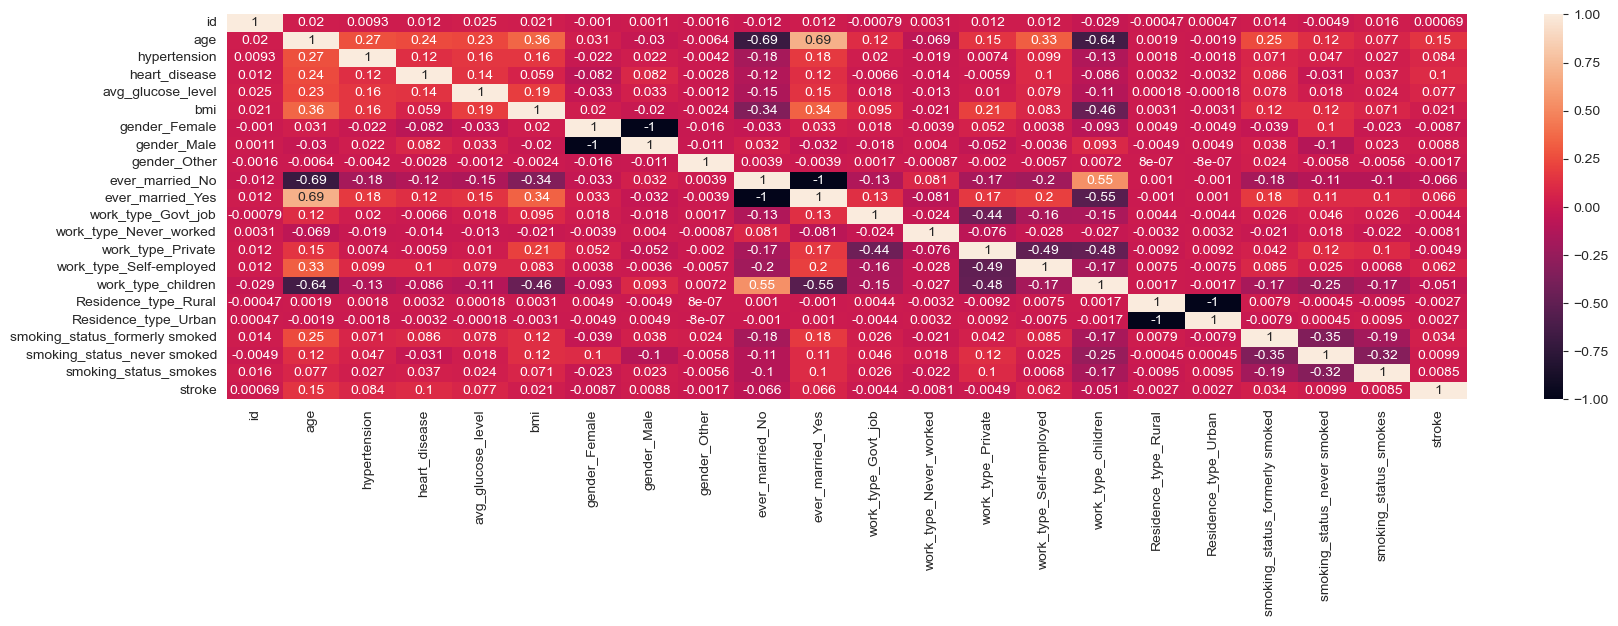

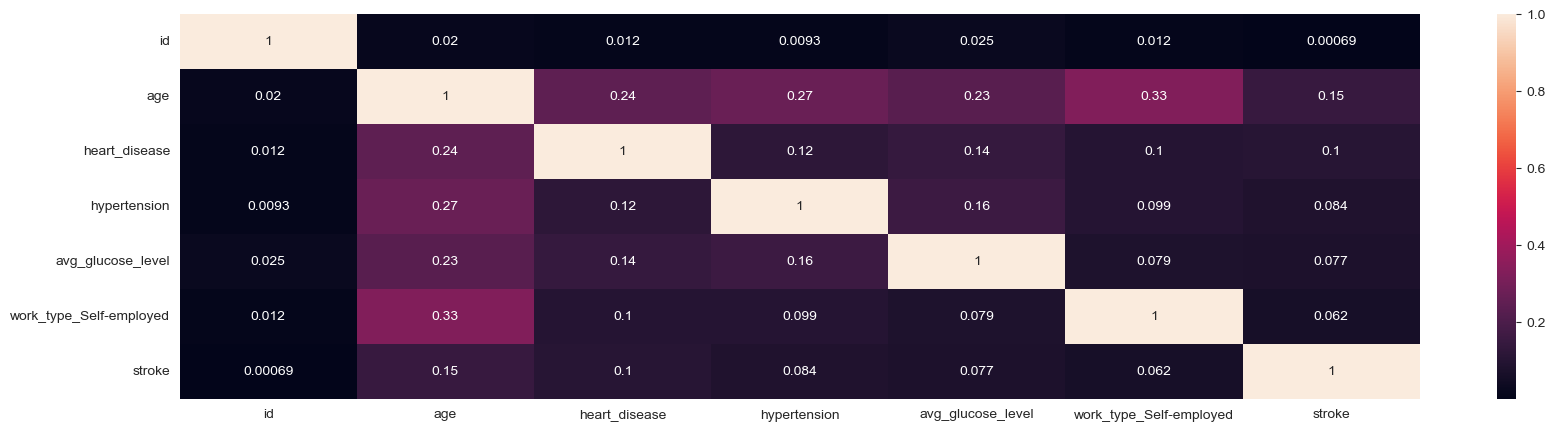

In [63]:
# Data correlaties:
# Pre-feature selectie
plt.figure(figsize=(20, 5))
sns.heatmap(df_train.corr(), annot=True)
# Nieuwe dataset met geselecteerde features + target
df_train_features = pd.DataFrame({
    'id': df_train['id'],
    'age': df_train['age'],
    'heart_disease': df_train['heart_disease'],
    'hypertension': df_train['hypertension'],
    'avg_glucose_level': df_train['avg_glucose_level'],
    'work_type_Self-employed': df_train['work_type_Self-employed'],
    'stroke': df_train['stroke']
})
# Post-feature selectie
plt.figure(figsize=(20, 5))
sns.heatmap(df_train_focus.corr(), annot=True)


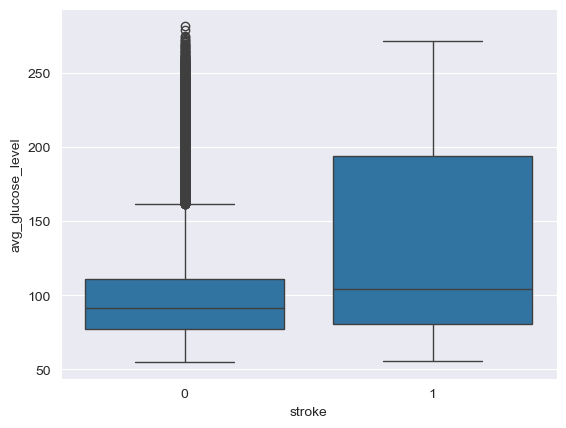

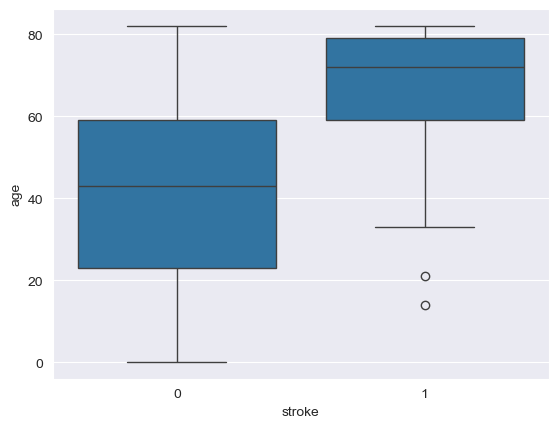

In [64]:
# Correlatie visualisatie voor non-boolean features met target "stroke"
sns.boxplot(data=df_train_features, x='stroke', y='avg_glucose_level')
plt.show()
sns.boxplot(data=df_train_features, x='stroke', y='age')
plt.show()

Skewness Kurtosis

Statistics for age:
count    33550.000000
mean        41.815312
std         22.477423
min          0.080000
25%         24.000000
50%         43.000000
75%         59.000000
max         82.000000
Name: age, dtype: float64
IQR: 35.00
Skewness: -0.08
Kurtosis: -1.00
Data is normaal verdeeld 3.924827960985624e-62.


C:\Users\mkako\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 33550.
  res = hypotest_fun_out(*samples, **kwds)


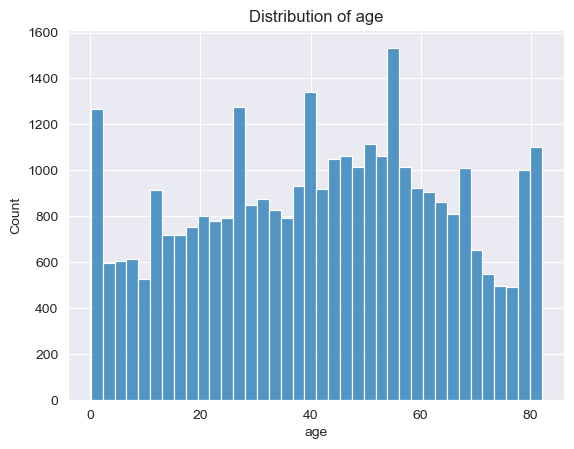

Statistics for avg_glucose_level:
count    33550.000000
mean       103.587081
std         42.127396
min         55.010000
25%         77.460000
50%         91.320000
75%        111.437500
max        281.590000
Name: avg_glucose_level, dtype: float64
IQR: 33.98
Skewness: 1.72
Kurtosis: 2.43
Data is normaal verdeeld 2.4180100982786272e-105.


C:\Users\mkako\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 33550.
  res = hypotest_fun_out(*samples, **kwds)


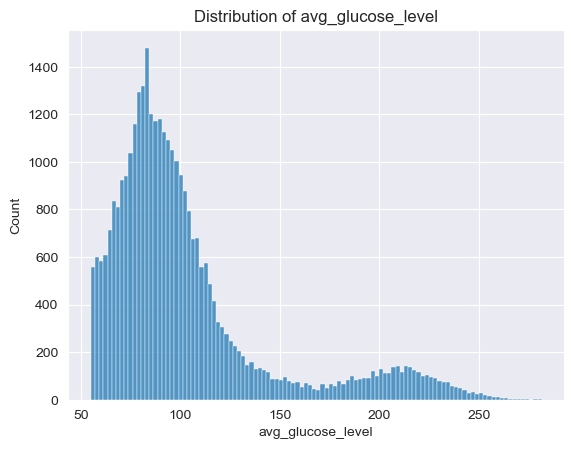

In [87]:
# Data verdeling
def statistieken_verdeling(df, col):
    """iqr, skewness en kurtosis voor een gegevene kolom voor data verdeling inzicht."""
    print(f"Statistics for {col}:")
    print(df[col].describe())
    print(f"IQR: {iqr(df[col]):.2f}")
    print(f"Skewness: {df[col].skew():.2f}")
    print(f"Kurtosis: {df[col].kurtosis():.2f}")
    stat, p = shapiro(df[col])
    if stat > 0.05:
        print(f"Data is normaal verdeeld {p}.")
    else:
        print("Data is niet normaal verdeeld.")
    sns.histplot(data=df, x=col)
    plt.title(f"Distribution of {col}")
    plt.show()

# Calculate stats for numeric columns
statistieken_verdeling(df_train_features, 'age')
statistieken_verdeling(df_train_features, 'avg_glucose_level')
